In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [4]:
### Anchor words

df = pd.read_excel('/Users/yvette/Desktop/data/List of anchor words.xlsx')

word_groups = {}

for idx, row in df.iterrows():
    dim_name = row['dimension']
    positive = row['positive']
    negative = row['negative']

    if dim_name not in word_groups:
        word_groups[dim_name] = {'positive': [], 'negative': []}
        
    word_groups[dim_name]['positive'].append(positive)
    word_groups[dim_name]['negative'].append(negative)

def clean_word_groups(word_groups):
    # Loop through each group and clean the 'positive' and 'negative' lists
    for group in word_groups.values():
        group['positive'] = [word.lower().replace(" ", "_") for word in group['positive'] if word is not np.nan]
        group['negative'] = [word.lower().replace(" ", "_") for word in group['negative'] if word is not np.nan]
    return word_groups

# Clean the word groups
word_groups = clean_word_groups(word_groups)

print(word_groups)

class SemanticDirection:
    def __init__(self, positive, negative):
        self.positive = positive
        self.negative = negative
        

semantic_directions = {}
# Create semantic direction objects for each dimension
for dim_name, words in word_groups.items():
    semantic_directions[dim_name] = SemanticDirection(words['positive'], words['negative'])


{'Democracy  vs.  Dictatorship': {'positive': ['democracy', 'polyarchy', 'pluralism', 'egalitarian', 'consensual', 'deliberative', 'participatory', 'liberal', 'feminism', 'social_democracy', 'representative'], 'negative': ['dictatorship', 'autocracy', 'authoritarianism', 'populism', 'erosion', 'coup', 'fascism', 'conservatism', 'backsliding', 'totalitarianism', 'oligarchy']}, 'Electoral': {'positive': ['directly_elected', 'electoral_competition', 'electoral_integrity', 'multiparty', 'multi_party', 'free_speech', 'free_press'], 'negative': ['appointed', 'appointment', 'electoral_authoritarianism', 'electoral_fraud', 'single_party', 'censorship', 'propaganda']}, 'Liberal': {'positive': ['independent_judiciary', 'legislative_oversight', 'transparent', 'civil_liberties', 'privacy', 'transparency'], 'negative': ['state_intervention', 'legislative_supremacy', 'corrupt', 'state_repression', 'surveillance', 'corruption']}, 'Deliberative': {'positive': ['discretion', 'rationale', 'common_good',

In [5]:
### Create dimension and calculate cosine similarity
def calc_wordlist_mean(wordlist, w2vmodel):
    # Skip words that are not found in the vocabulary
    wordlist = [w2vmodel.wv[i] for i in wordlist if i in w2vmodel.wv]
    
    # If no words were found, return a zero vector (or you could raise an exception, depending on your needs)
    if len(wordlist) == 0:
        print("Warning: No valid words found in the vocabulary.")
        return None
    
    # Compute the mean of the word vectors and normalize
    meanvec = np.mean(wordlist, axis=0)
    meanvec = normalize(meanvec.reshape(1, -1), norm='l2')  # normalize
    return meanvec.reshape(w2vmodel.vector_size,)

class Dimension:
    def __init__(self, semantic_direction, w2vmodel):  
        self.semantic_direction = semantic_direction  
        self.w2vmodel = w2vmodel  
        self.dimension_vec = self.calc_dim_larsen()

        if self.dimension_vec is None or not isinstance(self.dimension_vec, np.ndarray):
            raise ValueError("Error: `dimension_vec` is not properly calculated.")
    
    ## Larsen Method
    def calc_dim_larsen(self):
        pos_mean = calc_wordlist_mean(self.semantic_direction.positive, self.w2vmodel)
        neg_mean = calc_wordlist_mean(self.semantic_direction.negative, self.w2vmodel)
        
        # Skip the dimension if either positive or negative list is invalid (None)
        if pos_mean is None or neg_mean is None:
            print(f"Skipping dimension {self.semantic_direction} due to invalid word lists.")
            return None
        
        diffvec = pos_mean - neg_mean  
        diffvec = normalize(diffvec.reshape(1, -1), norm='l2')
        return diffvec.reshape(self.w2vmodel.vector_size,)
    
    def cos_sim(self, inputwords, returnNAs): 
        assert isinstance(inputwords, list), "Enter word(s) as a list, e.g., ['word']"
        interesting_dim = self.dimension_vec.reshape(1, -1) 
        cossims = []
        for word in inputwords:
            if word == 'nan' and returnNAs:
                cossims.append(np.nan)
            elif word != 'nan':
                try:
                    cossims.append(cosine_similarity(self.w2vmodel.wv[word].reshape(1, -1), interesting_dim)[0][0])
                except KeyError:
                    if returnNAs:
                        cossims.append(np.nan)
                    continue
        return cossims
    
    # Calculate cosine similarity between "democracy" and each dimension
    def calc_cosine_with_democracy(dimensions, w2vmodel, returnNAs=False):
        # Calculate cosine similarity of "democracy" with each dimension vector
        democracy_vector = w2vmodel.wv['democracy']
    
        for dim_name, dimension in dimensions.items():
            # Only calculate if dimension is valid
            if dimension.dimension_vec is not None:
                pos_sim = dimension.cos_sim([democracy_vector], returnNAs)
                print(f"Cosine similarity between 'democracy' and {dim_name} (positive side): {pos_sim}")

    # Calculate cosine similarity between dimensions
    def calc_cosine_between_dimensions(dim1, dim2):
        # Only calculate if both dimensions are valid
        if dim1.dimension_vec is not None and dim2.dimension_vec is not None:
            return cosine_similarity(dim1.dimension_vec.reshape(1, -1), dim2.dimension_vec.reshape(1, -1))[0][0]
        else:
            return np.nan


In [6]:
# Define the year ranges
year_ranges = [
    ("1971", "1980"),
    ("1981", "1990"),
    ("1991", "2000"),
    ("2001", "2010"),
    ("2011", "2020"),
    ("2021", "2024")
]

# Define the journals
journals = [
    "American Journal of Political Science",
    "British Journal of Political Science"
]

cos_sim_democracy = []
cos_sim_dimensions = []

# Iterate over each year range and journal
for start_year, end_year in year_ranges:
    for journal in journals:
        # Create the subcorpus name (e.g., 1971-1980_American Journal of Political Science)
        subcorpus_name = f"{start_year}-{end_year}_{journal}"

        print(f"Processing subcorpus: {subcorpus_name}...")

        # Loop over the 25 bootstrap samples
        for i in range(0, 25):  
            model_path = f'/Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_{subcorpus_name}_boot{i}_.model'

            try:
                # Load the Word2Vec model for the current bootstrap sample
                model = Word2Vec.load(model_path)
                print(f"Loaded model: {model_path}")

                # Check if "democracy" is in the vocabulary
                if "democracy" not in model.wv:
                    print(f"Warning: 'democracy' not found in model {i} for {subcorpus_name}")
                    continue

                democracy_vector = model.wv["democracy"]

                # Initialize Dimensions (skip invalid dimensions if any)
                dimensions = {}
                for dim_name in semantic_directions:
                    dimension = None
                    try:
                        # Try creating the dimension object
                        dimension = Dimension(semantic_directions[dim_name], model)

                        # If the dimension_vec is None, just skip this dimension
                        if dimension.dimension_vec is None:
                            print(f"Warning: Invalid dimension vector for {dim_name}, skipping...")
                            continue

                        # If dimension_vec is valid, add to dimensions
                        dimensions[dim_name] = dimension
                    except Exception as e:
                        print(f"Error processing dimension {dim_name}: {e}, skipping...")

                # Check if any valid dimensions were found
                if not dimensions:
                    print("Warning: No valid dimensions found. Skipping...")
                    continue

                # Compute cosine similarity between "democracy" and each valid dimension
                for dim_name, dimension in dimensions.items():
                    pos_sim = dimension.cos_sim(["democracy"], returnNAs=False)

                    # Create the new row for cosine similarity with "democracy"
                    cos_sim_democracy.append({
                        "Subcorpus": subcorpus_name,
                        "Bootstrap": i,
                        "Dimension": dim_name,
                        "Cosine_Similarity": pos_sim[0] if pos_sim else np.nan
                    })

                # Compute cosine similarity between each pair of valid dimensions
                dim_names = list(dimensions.keys())
                for j in range(len(dim_names)):
                    for k in range(j + 1, len(dim_names)):
                        dim1 = dimensions[dim_names[j]]
                        dim2 = dimensions[dim_names[k]]

                        # Compute cosine similarity between two dimensions
                        sim = cosine_similarity(dim1.dimension_vec.reshape(1, -1), dim2.dimension_vec.reshape(1, -1))[0][0]

                        # Create the new row for cosine similarity between dimensions
                        cos_sim_dimensions.append({
                            "Subcorpus": subcorpus_name,
                            "Bootstrap": i,
                            "Dimension 1": dim_names[j],
                            "Dimension 2": dim_names[k],
                            "Cosine_Similarity": sim
                        })

            except FileNotFoundError:
                print(f"Model file not found: {model_path}, skipping...")


Processing subcorpus: 1971-1980_American Journal of Political Science...
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot0_.model
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot1_.model
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot2_.model
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot3_.model
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot4_.model
Loaded model: /Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_1971-1980_American Journal of Political Science_boot5_.model
Loa

In [7]:
cos_sim_democracy_df = pd.DataFrame(cos_sim_democracy)
cos_sim_dimensions_df = pd.DataFrame(cos_sim_dimensions)
cos_sim_democracy_df.to_csv('/Users/yvette/Desktop/data/Final/cos_sim_democracy.csv', index=False)
cos_sim_dimensions_df.to_csv('/Users/yvette/Desktop/data/Final/cos_sim_dimensions.csv', index=False)

In [8]:
### Descriptive statistics
agg_df_democracy = cos_sim_democracy_df.groupby(['Subcorpus', 'Dimension'])['Cosine_Similarity'].agg(
    mean='mean', 
    std='std', 
    min='min', 
    max='max'
).reset_index()

# Create a new column 'Dimension Pair' by combining 'Dimension 1' and 'Dimension 2'
cos_sim_dimensions_df['Dimension_Pair'] = cos_sim_dimensions_df['Dimension 1'] + ' & ' + cos_sim_dimensions_df['Dimension 2']
# Group by 'Subcorpus' and 'Dimension Pair', then calculate mean, std, min, and max of 'Cosine Similarity'
agg_df_dimension = cos_sim_dimensions_df.groupby(['Subcorpus', 'Dimension_Pair'])['Cosine_Similarity'].agg(
    mean='mean', 
    std='std', 
    min='min', 
    max='max'
).reset_index()

agg_df_democracy.to_csv('/Users/yvette/Desktop/data/Final/agg_df_democracy.csv', index=False)
agg_df_dimension.to_csv('/Users/yvette/Desktop/data/Final/agg_df_dimension.csv', index=False)

In [9]:
cos_sim_democracy_df['Journal']= cos_sim_democracy_df['Subcorpus'].apply(lambda x: 'American' if 'American' in x else 'British')
cos_sim_democracy_df['Decade'] = cos_sim_democracy_df['Subcorpus'].apply(lambda x: x.split('_')[0][:4] + 's')
cos_sim_democracy_descriptive = cos_sim_democracy_df.groupby(['Journal','Dimension'], as_index=False)['Cosine_Similarity'].agg(
    mean='mean', 
    std='std', 
    min='min', 
    max='max'
).reset_index()
cos_sim_democracy_descriptive.to_csv('/Users/yvette/Desktop/data/Final/desciptive_df_democracy.csv', index=False)
# Create a new column 'Dimension Pair' by combining 'Dimension 1' and 'Dimension 2'
cos_sim_dimensions_df['Dimension Pair'] = cos_sim_dimensions_df['Dimension 1'] + ' & ' + cos_sim_dimensions_df['Dimension 2']
cos_sim_dimensions_df['Journal']= cos_sim_dimensions_df['Subcorpus'].apply(lambda x: 'American' if 'American' in x else 'British')
cos_sim_dimensions_df['Decade'] = cos_sim_dimensions_df['Subcorpus'].apply(lambda x: x.split('_')[0][:4] + 's')
cos_sim_dimensions_descriptive = cos_sim_dimensions_df.groupby(['Journal','Dimension Pair'], as_index=False)['Cosine_Similarity'].agg(
    mean='mean', 
    std='std', 
    min='min', 
    max='max'
).reset_index()
cos_sim_dimensions_descriptive.to_csv('/Users/yvette/Desktop/data/Final/descriptive_df_dimensions.csv', index=False)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_all_dimensions(csv_file, output_folder):
    """
    Plot the mean cosine similarity over the decades for all dimensions in the dataset,
    distinguishing American and British journals.
    
    Parameters:
    - csv_file (str): Path to the CSV file containing 'subcorpus', 'Dimension', and 'mean'.
    - output_folder (str): Folder to save the generated plots.
    """
    # Load the dataset
    df = pd.read_csv(csv_file)
    
    # Add a column to identify the journal (American or British)
    df['Journal'] = df['Subcorpus'].apply(lambda x: 'American' if 'American' in x else 'British')
    
    # Add a 'Decade' column for grouping by decades
    df['Decade'] = df['Subcorpus'].apply(lambda x: x.split('_')[0][:4] + 's')
    
    # Get all unique dimensions
    dimensions = df['Dimension'].unique()
    
    # Define colors for American and British journals (culturally meaningful)
    palette = {'American': '#3A3A6B', 'British': '#C8102E'}  # Deep Blue for U.S., Deep Red for UK
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    for dimension in dimensions:
        # Filter for the specific dimension
        dimension_df = df[df['Dimension'] == dimension]
        
        # Aggregate the mean cosine similarity by Decade and Journal
        aggregated_df = dimension_df.groupby(['Decade', 'Journal'], as_index=False)['mean'].mean()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=aggregated_df, x='Decade', y='mean', hue='Journal', 
                     style='Journal', markers=True, dashes=False, palette=palette)
        
        # Customize the plot
        plt.title(f'Mean Cosine Similarity for Dimension: "{dimension}" Across Decades')
        plt.xlabel('Decade')
        plt.ylabel('Mean Cosine Similarity')
        plt.xticks(rotation=45)
        
        # Save the plot
        plot_path = os.path.join(output_folder, f"{dimension.replace(' ', '_')}_mean.png")
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

# Example usage:
plot_all_dimensions('agg_df_democracy.csv', 'output_plots_dimensions')


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_all_dimension_pairs(csv_file, output_folder):
    """
    Plot the mean cosine similarity over the decades for all dimension pairs in the dataset,
    distinguishing American and British journals.
    
    Parameters:
    - csv_file (str): Path to the CSV file containing 'subcorpus', 'Dimension Pair', and 'mean'.
    - output_folder (str): Folder to save the generated plots.
    """
    # Load the dataset
    df = pd.read_csv(csv_file)
    
    # Add a column to identify the journal (American or British)
    df['Journal'] = df['Subcorpus'].apply(lambda x: 'American' if 'American' in x else 'British')
    
    # Add a 'Decade' column for grouping by decades
    df['Decade'] = df['Subcorpus'].apply(lambda x: x.split('_')[0][:4] + 's')
    
    # Get all unique dimension pairs
    dimension_pairs = df['Dimension_Pair'].unique()
    
    # Define colors for American and British journals (culturally meaningful)
    palette = {'American': '#3A3A6B', 'British': '#C8102E'}  # Deep Blue for U.S., Deep Red for UK
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    for dimension_pair in dimension_pairs:
        # Filter for the specific dimension pair
        dimension_pair_df = df[df['Dimension_Pair'] == dimension_pair]
        
        # Aggregate the mean cosine similarity by Decade and Journal
        aggregated_df = dimension_pair_df.groupby(['Decade', 'Journal'], as_index=False)['mean'].mean()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=aggregated_df, x='Decade', y='mean', hue='Journal', 
                     style='Journal', markers=True, dashes=False, palette=palette)
        
        # Customize the plot
        plt.title(f'Mean Cosine Similarity for Dimension Pair: "{dimension_pair}" Across Decades')
        plt.xlabel('Decade')
        plt.ylabel('Mean Cosine Similarity')
        plt.xticks(rotation=45)
        
        # Save the plot
        plot_path = os.path.join(output_folder, f"{dimension_pair.replace(' ', '_')}_mean.png")
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

# Example usage:
plot_all_dimension_pairs('agg_df_dimension.csv', 'output_plots_dimension_pairs')


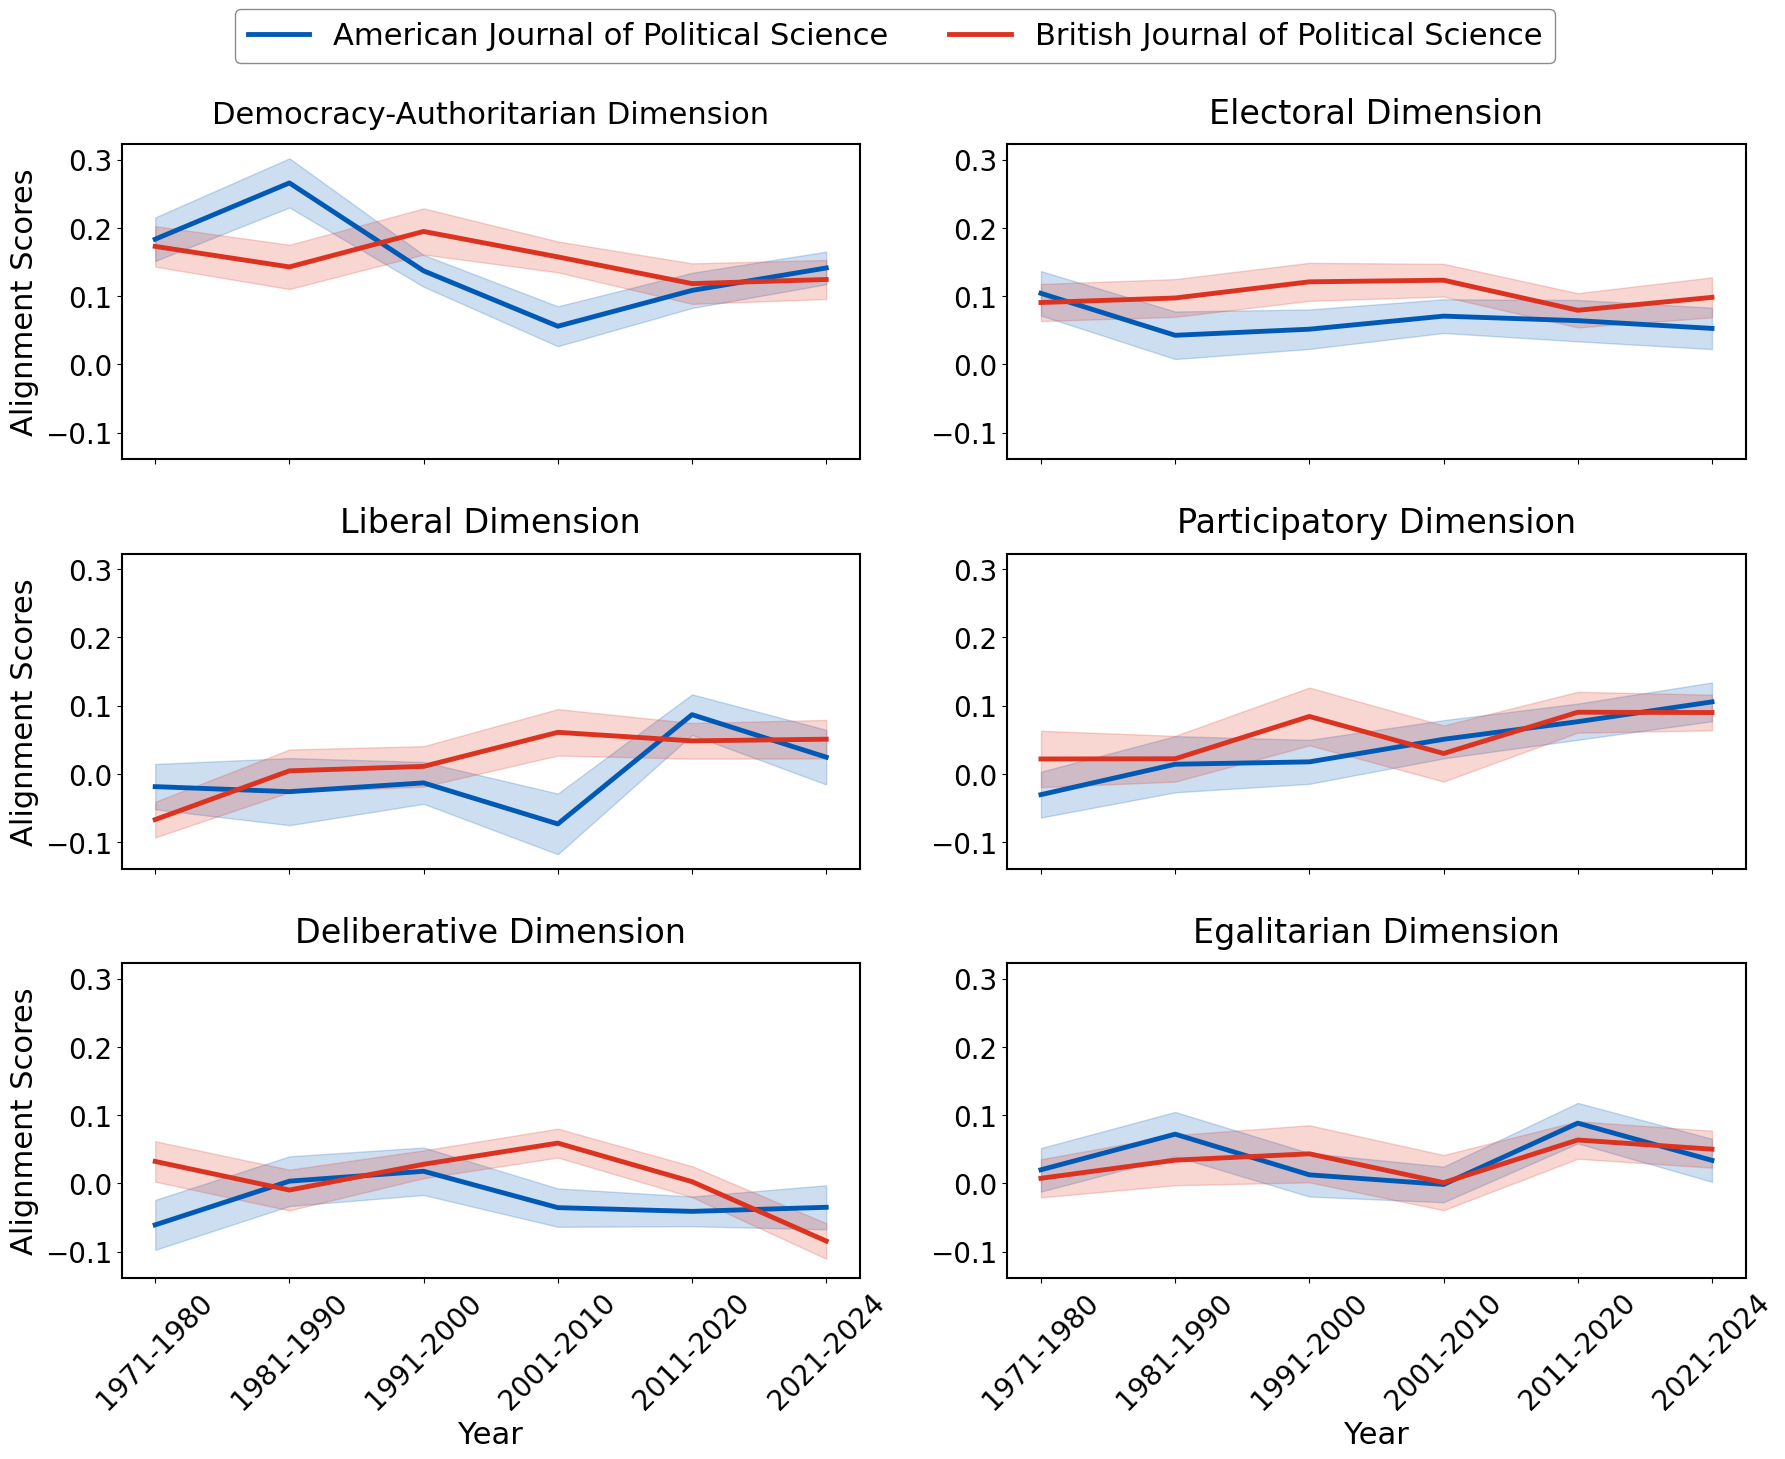

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
df = pd.read_csv('/Users/yvette/Desktop/data/Final/agg_df_democracy.csv')

# Extract year information from Subcorpus - this will be used directly for x-axis labels
df['Year'] = df['Subcorpus'].str.split('_').str[0]

# Extract journal information
df['Journal'] = df['Subcorpus'].str.split('_').str[1]

# Calculate confidence intervals (92%)
# For 92% confidence interval, z-score is approximately 1.75
z_score = 1.75

# Define the custom order of dimensions
dimension_order = ['Democracy  vs.  Dictatorship','Electoral', 'Liberal', 'Participatory', 'Deliberative', 'Egalitarian']

# Filter dimensions in the dataset to match our custom order
available_dimensions = [dim for dim in dimension_order if dim in df['Dimension'].unique()]

# Define colors for different journals
colors = {
    'British': '#DC3220',
    'American': '#005AB5'
}

# Identify journal countries based on full journal names
def categorize_journal(journal_name):
    if 'American' in journal_name:
        return 'American'
    elif 'British' in journal_name:
        return 'British'
    else:
        return 'Other'

df['Country'] = df['Journal'].apply(categorize_journal)

# Create a faceted plot with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(18, 15), sharex=True)
# Convert axes to 1D array for easy indexing
axes = axes.flatten()

# Store y-limits to standardize later
y_min = float('inf')
y_max = float('-inf')

# First pass to determine common y-axis limits
for dimension in available_dimensions:
    dim_df = df[df['Dimension'] == dimension].copy()
    for _, group in dim_df.groupby(['Journal', 'Country']):
        ci_lower = group['mean'] - z_score * group['std'] / np.sqrt(len(group))
        ci_upper = group['mean'] + z_score * group['std'] / np.sqrt(len(group))
        y_min = min(y_min, ci_lower.min())
        y_max = max(y_max, ci_upper.max())

# Add some padding to y-limits
y_range = y_max - y_min
y_min -= 0.05 * y_range
y_max += 0.05 * y_range

# Get unique year values for x-axis
unique_years = sorted(df['Year'].unique())

# Plot each dimension in a separate subplot, following the custom order
for i, dimension in enumerate(available_dimensions):
    if i < len(axes):  # Make sure we don't exceed the number of subplots
        ax = axes[i]
        
        dim_df = df[df['Dimension'] == dimension].copy()

        # Plot each journal line for this dimension
        for journal, group in dim_df.groupby('Journal'):
            # Sort by year for proper line plotting
            group = group.sort_values('Year')
            country = group['Country'].iloc[0]
            color = colors.get(country, 'gray')

            # Calculate confidence intervals
            ci_lower = group['mean'] - z_score * group['std'] / np.sqrt(len(group))
            ci_upper = group['mean'] + z_score * group['std'] / np.sqrt(len(group))

            # Plot the mean line with increased linewidth and assign a label for the legend
            # Only include label in the first subplot to avoid duplicate legend entries
            if i == 0:
                ax.plot(group['Year'], group['mean'], '-', color=color, linewidth=3.5, label=journal)
            else:
                ax.plot(group['Year'], group['mean'], '-', color=color, linewidth=3.5)

            # Plot confidence interval
            ax.fill_between(group['Year'], ci_lower, ci_upper, color=color, alpha=0.2)

        # Set consistent y-limits for all subplots
        ax.set_ylim(y_min, y_max)

        # Set ticks from rounded y_min to rounded y_max with a step of 0.1
        ax.set_yticks(np.arange(round(y_min, 1), round(y_max, 1) + 0.01, 0.1))

        # Set x-ticks to be the unique years directly
        ax.set_xticks(range(len(unique_years)))
        ax.set_xticklabels(unique_years, fontsize=20)

        # Show x-axis only for bottom row (Deliberative and Egalitarian)
        if i >= 4:  
            ax.set_xticks(range(len(unique_years)))
            ax.set_xticklabels(unique_years, fontsize=20, rotation=45)
            ax.set_xlabel('Year', fontsize=22)
        else:
            ax.set_xticks([])
            ax.set_xticklabels([])

        # Set y-axis tick label font size
        ax.tick_params(axis='y', labelsize=20)
        
        # Set y-axis label only for left column
        if i % 2 == 0:  # Left column
            ax.set_ylabel('Alignment Scores', fontsize=22)

        # Customize the subplot with larger fonts
        if dimension == 'Democracy  vs.  Dictatorship':
            ax.set_title('Democracy-Authoritarian Dimension', fontsize=22, pad=15)
        else:
            ax.set_title(f'{dimension} Dimension', fontsize=24, pad=15)

        # Thicker axis lines
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='upper center',
           bbox_to_anchor=(0.5, 0.98),  # Position at top of figure
           framealpha=0.9, edgecolor='gray', fancybox=True,
           fontsize=22, ncol=2)

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.3, wspace=0.2)

# Save the figure with high resolution for Word document
plt.savefig('democracy_dimensions_grid_for_word.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

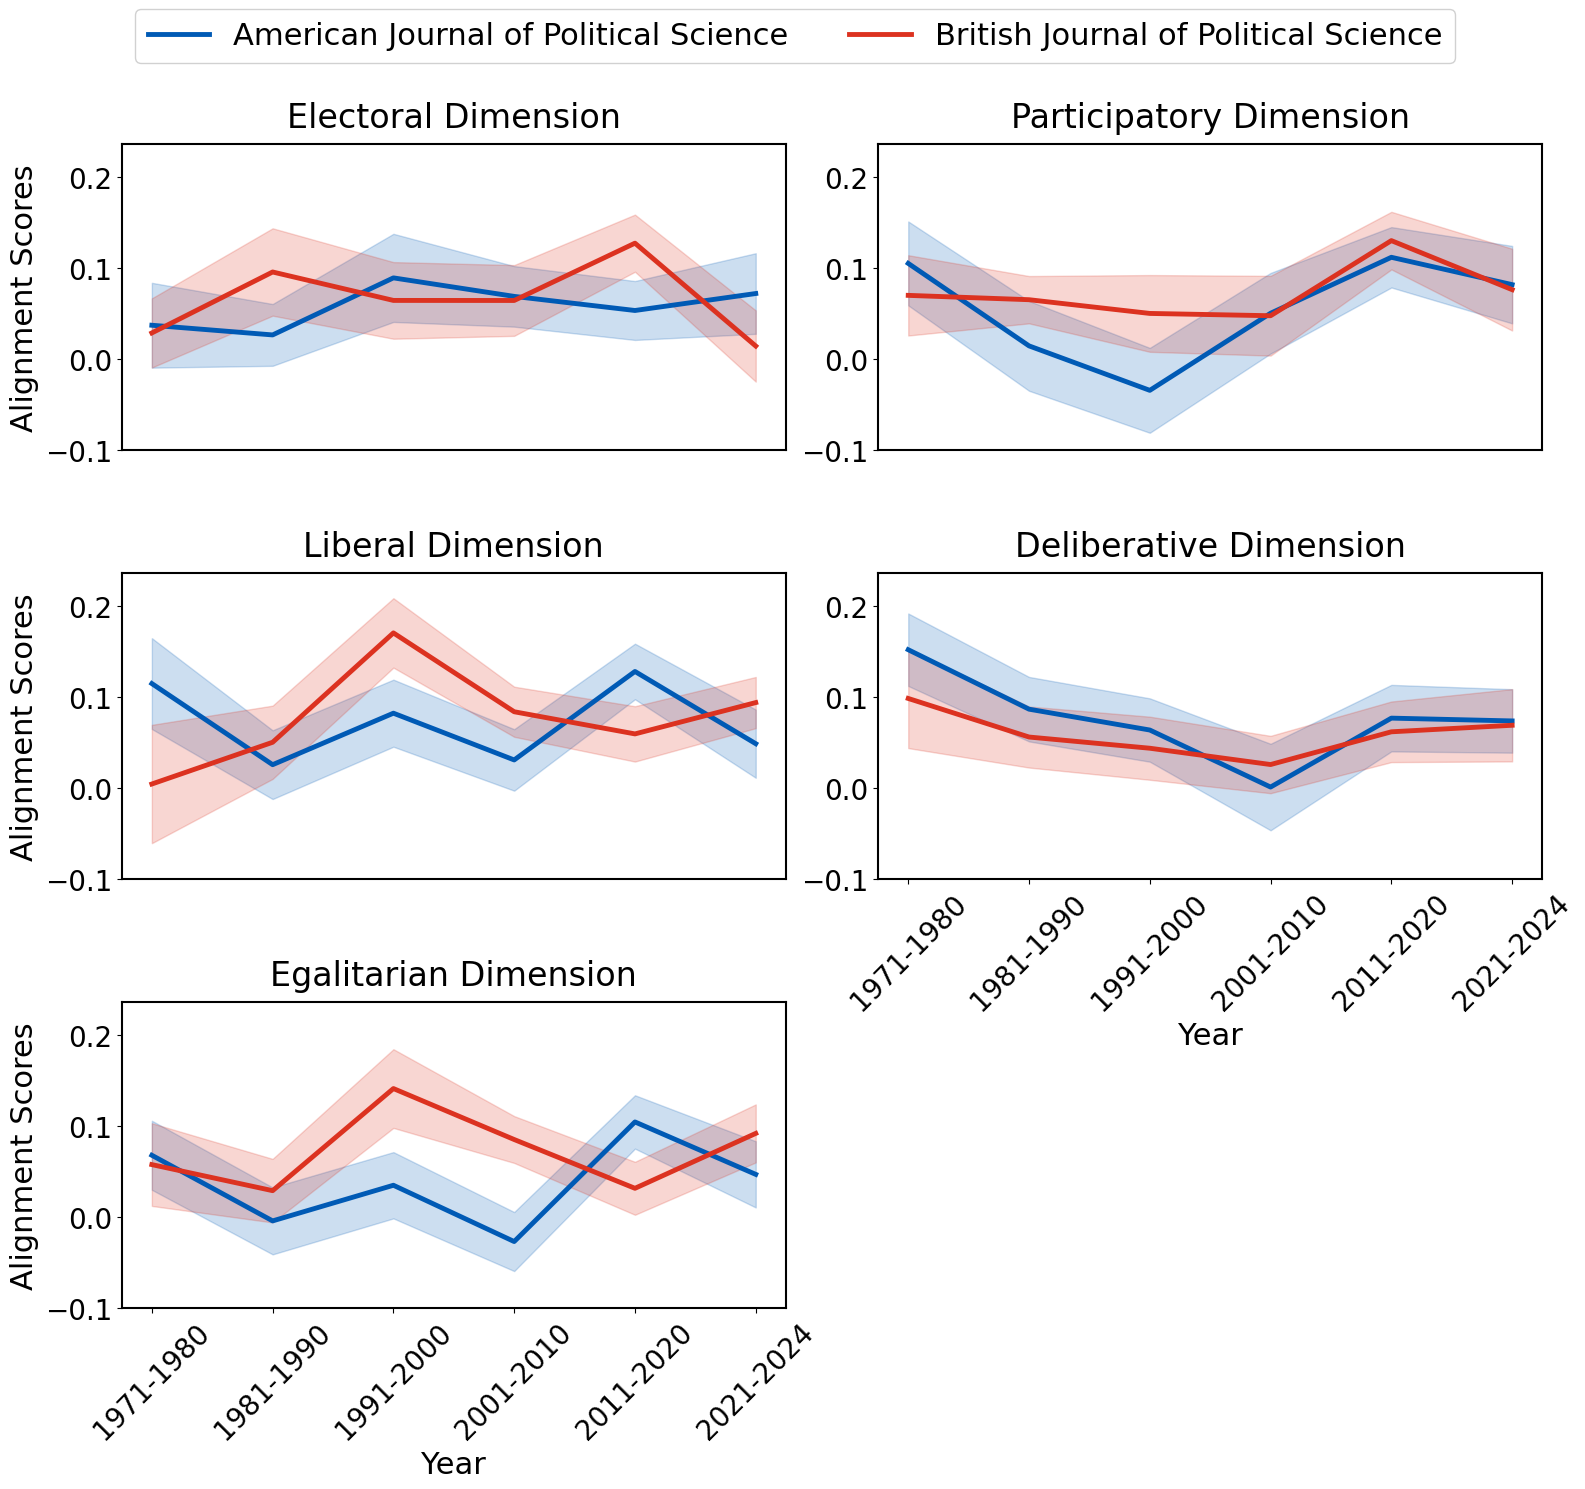

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
df = pd.read_csv('/Users/yvette/Desktop/data/Final/agg_df_dimension.csv')

# Define the list of Dimension_Pair values you want to keep
dimension_pairs_to_keep = [
    'Democracy  vs.  Dictatorship & Deliberative',
    'Democracy  vs.  Dictatorship & Egalitarian',
    'Democracy  vs.  Dictatorship & Electoral',
    'Democracy  vs.  Dictatorship & Liberal',
    'Democracy  vs.  Dictatorship & Participatory'
]

# Filter the DataFrame
df_filtered = df[df['Dimension_Pair'].isin(dimension_pairs_to_keep)].copy()

# Extract Year and Journal from Subcorpus
df_filtered['Year'] = df_filtered['Subcorpus'].str.split('_').str[0]
df_filtered['Journal'] = df_filtered['Subcorpus'].str.split('_').str[1]
df_filtered['Year_Num'] = df_filtered['Year'].str.split('-').str[0].astype(int)

# Calculate confidence intervals (92%)
z_score = 1.75

# Custom dimension order
dimension_order = [
    'Democracy  vs.  Dictatorship & Electoral', 
    'Democracy  vs.  Dictatorship & Participatory',
    'Democracy  vs.  Dictatorship & Liberal', 
    'Democracy  vs.  Dictatorship & Deliberative', 
    'Democracy  vs.  Dictatorship & Egalitarian'
]

available_dimensions = [dim for dim in dimension_order if dim in df_filtered['Dimension_Pair'].unique()]

# Define journal colors
colors = {
    'British': '#DC3220',
    'American': '#005AB5'
}

# Categorize journals
def categorize_journal(journal_name):
    if 'American' in journal_name:
        return 'American'
    elif 'British' in journal_name:
        return 'British'
    else:
        return 'Other'

df_filtered['Country'] = df_filtered['Journal'].apply(categorize_journal)

# Create 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

# Hide last subplot (only 5 dimensions)
axes[-1].axis('off')

# Unique year labels
decade_mapping = df_filtered[['Year', 'Year_Num']].drop_duplicates().sort_values('Year_Num')

# Y-axis bounds
y_min = df_filtered['mean'].min() - z_score * df_filtered['std'].max() / np.sqrt(df_filtered.groupby('Dimension_Pair').size().min())
y_max = df_filtered['mean'].max() + z_score * df_filtered['std'].max() / np.sqrt(df_filtered.groupby('Dimension_Pair').size().min())
y_min -= 0.02
y_max += 0.02

# Plot each dimension
for i, dimension in enumerate(available_dimensions):
    ax = axes[i]
    dim_df = df_filtered[df_filtered['Dimension_Pair'] == dimension].copy()

    for journal, group in dim_df.groupby('Journal'):
        group = group.sort_values('Year_Num')
        country = group['Country'].iloc[0]
        color = colors.get(country, 'gray')

        ci_lower = group['mean'] - z_score * group['std'] / np.sqrt(len(group))
        ci_upper = group['mean'] + z_score * group['std'] / np.sqrt(len(group))

        ax.plot(group['Year_Num'], group['mean'], '-', color=color, linewidth=3.5, label=journal)
        ax.fill_between(group['Year_Num'], ci_lower, ci_upper, color=color, alpha=0.2)

    # Y-axis
    ax.set_ylim(y_min, y_max)
    if i % 2 == 0:
        ax.set_ylabel('Alignment Scores', fontsize=22)
    else:
        ax.set_ylabel('')

    # Title
    title = dimension.replace('Democracy  vs.  Dictatorship & ', '')
    ax.set_title(f'{title} Dimension', fontsize=24, pad=12)

    # X-axis ticks and labels
    # Show x-axis labels only for Deliberative and Egalitarian
    if dimension in ['Democracy  vs.  Dictatorship & Deliberative', 'Democracy  vs.  Dictatorship & Egalitarian']:
        ax.set_xticks(decade_mapping['Year_Num'])
        ax.set_xticklabels(decade_mapping['Year'], fontsize=20, rotation=45)
        ax.set_xlabel('Year', fontsize=22)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel('')

    # Thicker axes
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    ax.tick_params(axis='y', labelsize=20)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
           framealpha=0.9, fontsize=22, ncol=2)

# Layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)

# Save and show
plt.savefig('dimensions_pairs_3x2_grid.png', dpi=500, bbox_inches='tight')
plt.show()
